## Imports

In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

## Architecture

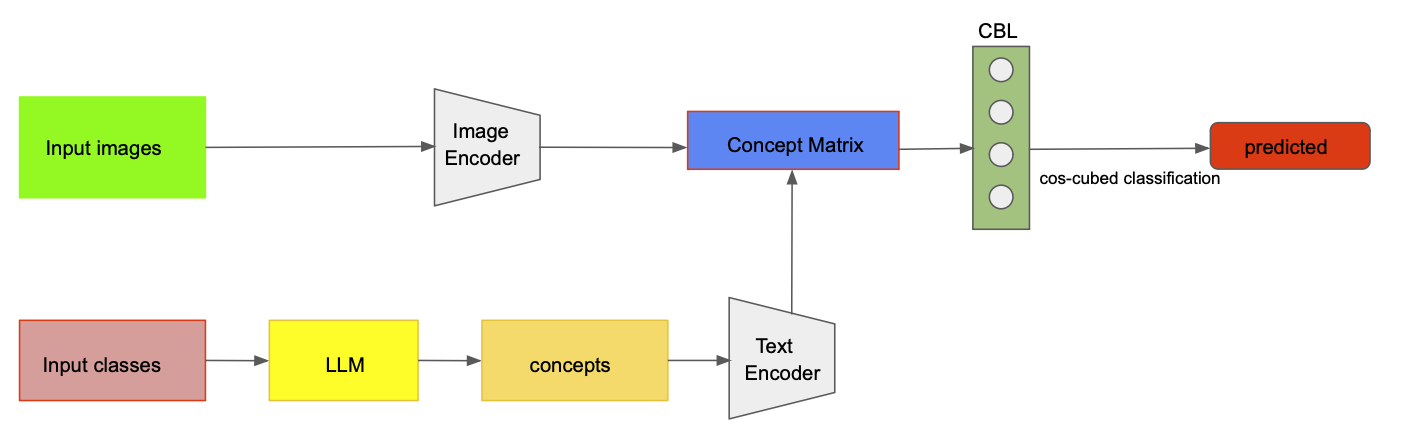

## Image Encoder

here we use ViT architecture

Subclass torch's LayerNorm to handle fp16

In [2]:
class LayerNorm(nn.LayerNorm):
  def forward(self, x: torch.Tensor):
      original_type = x.dtype
      ret = super().forward(x.type(torch.float32))
      return ret.type(original_type)

In [3]:
class QuickGELU(nn.Module):
  def forward(self, x: torch.Tensor):
      return x * torch.sigmoid(1.702 * x)

In [4]:
class ResidualAttentionBlock(nn.Module):
  def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):

      super().__init__()

      self.attn = nn.MultiheadAttention(d_model, n_head)
      self.ln_1 = LayerNorm(d_model)
      self.mlp = nn.Sequential(OrderedDict([
          ("c_fc", nn.Linear(d_model, d_model * 4)),
          ("gelu", QuickGELU()),
          ("c_proj", nn.Linear(d_model * 4, d_model))
      ]))
      self.ln_2 = LayerNorm(d_model)
      self.attn_mask = attn_mask

  def attention(self, x: torch.Tensor):
      self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
      return self.attn_mask(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

  def forward(self, x: torch.Tensor):
      x = x + self.attention(self.ln_1(x))
      x = x + self.mlp(self.ln_2(x))
      return x

simple transformer which uses Residual blocks

In [5]:
class Transformer(nn.Module):
  def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
      super().__init__()
      self.width = width
      self.layers = layers
      self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

  def forward(self, x: torch.Tensor):
      return self.resblocks(x)

In [6]:
class ImageEncoder(nn.Module): # Vision Transformer

  def __init__(self, input_dim: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
    super().__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

    scale = width ** -0.5
    self.concept_embed = nn.Parameter(scale * torch.randn(width))
    self.positional_embed = nn.Parameter(scale * torch.randn((input_dim // patch_size)**2 + 1, width))
    self.ln_pre = nn.LayerNorm(width)

    self.transformer = Transformer(width, layers, heads)

    self.ln_post = LayerNorm(width)
    self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

  def forward(self, x: torch.Tensor):
    x = self.conv1(x)
    x = x.reshape(x.shape[0], x.shape[1], -1) # shape = [*, width, grid**2]
    x = x.permute(0, 2, 1)
    x = torch.cat([self.concept_embed.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1) # shape = [*, grid ** 2 + 1, width]
    x = x + self.positional_embed.to(x.dtype) # not in-place operation intstead of +=
    x = self.ln_pre(x)

    x = x.permute(1, 0, 2)
    x = self.transformer(x)
    x = x.permute(1, 0, 2)

    x = self.ln_post(x[:, 0, :])

    if self.proj is not None:
      x = x @ self.proj

    return x

in kinda CLIP architectures we will often try to use ModifiedResNet novelty

it is like a simple ResNet but with some updates:

*   There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool
*   Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
*   The final pooling layer is a QKV attention instead of an average pool



also we need Bottleneck block for this

In [7]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        indentity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2d(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out

In [8]:
class AttentionPool2d(nn.Module):

    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embed = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)
        x = x + self.positional_embed[:, None, :].to(x.dtype)
        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.squeeze(0)


and now ModifiedResNet

In [9]:
class ModifiedResNet(nn.Module):

  def __init__(self, layers, output_dim, heads, input_dim=224, width=64):
    super().__init__()
    self.output_dim = output_dim
    self.input_dim = input_dim

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=width // 2, kernel_size=3, stride=2, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(width // 2)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(in_channels=width // 2, out_channels=width // 2, kernel_size=3, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(width // 2)
    self.relu2 = nn.ReLU(inplace=True)
    self.conv3 = nn.Conv3d(in_channels=width // 2, out_channels=width, kernel_size=3, padding=1, bias=False)
    self.bn3 = nn.BatchNorm2d(width)
    self.relu3 = nn.ReLU(inplace=True)
    self.avgpool = nn.AvgPool2d(2)

    self._inplanes = width # mutable variable
    self.layer1 = self._make_layer(width, layers[0])
    self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
    self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
    self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

    embed_dim = width * 32
    self.attnpool = AttentionPool2d(input_dim // 32, embed_dim, heads, output_dim)

  def _make_layer(self, planes, blocks, stride=1):
      layers = [Bottleneck(self._inplanes, planes, stride)]

      self._inplanes = planes * Bottleneck.expansion
      for _ in range(1, blocks):
          layers.append(Bottleneck(self._inplanes, planes))

      return nn.Sequential(*layers)

  def forward(self, x):
      def stem(x):
          x = self.relu1(self.bn1(self.conv1(x)))
          x = self.relu2(self.bn2(self.conv2(x)))
          x = self.relu3(self.bn3(self.conv3(x)))
          x = self.avgpool(x)

          return x

      x = x.type(self.conv1.weight.dtype)
      x = stem(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgpool(x)

      return x

## Text Encoder

here we use Transformer architecture

## CLIP

In [12]:
from typing import Tuple, Union

class CLIPmodel(nn.Module):

  def __init__(self,
               embed_dim: int,
               # vision
               input_dim: int,
               vision_layers: Union[Tuple[int, int, int, int], int],
               vision_width: int,
               vision_patch_size: int,
               # text
               context_length: int,
               vocab_size: int,
               transformer_width: int,
               transformer_heads: int,
               transformer_layers: int
              ):
      super().__init__()

      self.context_length = context_length

      if isinstance(vision_layers, (tuple, list)):
          vision_heads = vision_width * 32 // 64
          self.visual = ModifiedResNet(
              layers=vision_layers,
              output_dim=embed_dim,
              heads=vision_heads,
              input_dim=input_dim,
              width=vision_width
          )
      else:
          vision_heads=vision_width // 64
          self.visual = ImageEncoder(
              input_dim=input_dim,
              patch_size=vision_patch_size,
              width=vision_width,
              layers=vision_layers,
              heads=vision_heads,
              ouput_dim=embed_dim
          )
      self.transformer = Transformer(
          width=transformer_width,
          layers=transformer_layers,
          heads=transformer_heads,
          attn_mask=self.build_attention_mask()
      )

      self.vocab_size = vocab_size
      self.token_embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=transformer_width)
      self.positional_embed = nn.Parameter(torch.empty(self.context_length, transformer_width))
      self.ln_final = LayerNorm(transformer_width)

      self.text_projection = nn.Parameter(torch.empty(self.context_length, transformer_width))
      self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

      self.initialize_parameters()

  def initialize_parameters(self):
      # i will use xavier instead of normal later
      nn.init.normal_(self.token_embed.weight, std=0.02)
      nn.init.normal_(self.positional_embed, std=0.01)
      #nn.init.xavier_uniform_(self.token_embed.weight, gain=1.0)
      #nn.init.xavier_uniform_(self.positional_embed, gain=1.0)

      if isinstance(self.visual, ModifiedResNet):
          if self.visual.attnpool is None:
              std = self.visual.attnpool.c_proj.in_features ** -0.5
              nn.init.xavier_uniform_(self.visual.attnpool.q_proj.weight, std=std)
              nn.init.xavier_uniform_(self.visual.attnpool.k_proj.weight, std=std)
              nn.init.xavier_uniform_(self.visual.attnpool.v_proj.weight, std=std)
              nn.init.xavier_uniform_(self.visual.attnpool.c_proj.weight, std=std)

          for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
              for name, param in resnet_block.named_parameters():
                  if name.endswith("bn3.weight"):
                      nn.init.zeros_(param)

      proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
      attn_std = self.transformer.width ** -0.5
      fc_std = (2 * self.transformer.width) ** -0.5
      for block in self.transformer.resblocks:
          nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
          nn.init.normal_(block.attn.out_proj_weight, std=proj_std)
          nn.init.normal_(block.mlp.fc_proj_weight, std=fc_std)
          nn.init.normal_(block.mlp.c_proj_weight, std=proj_std)

      if self.text_projection is not None:
          nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

  def build_attention_mask(self):
      mask = torch.empty(self.context_length, self.context_length)
      mask.fill_(float("-inf"))
      mask.triu_(1)
      return mask

  @property
  def dtype(self):
      return self.visual.conv1.weight.dtype

  def encode_image(self, image):
      return self.visual(image.type(self.dtype))

  def encode_text(self, text):
      x = self.token_embed(text).type(self.dtype)
      x = x + self.positional_embed.type(self.dtype)
      x = x.permute(1, 0, 2)
      x = self.transformer(x)
      x = x.permute(1, 0, 2)
      x = self.ln_final(x).type(self.dtype)
      x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

      return x

  def forward(self, image, text):
      image_features = self.encode_image(image)
      text_image = self.encode_text(text)

      image_features = image_features / image_features.norm(dim=1, keepdim=True)
      text_features = text_features / text_features.norm(dim=1, keepdim=True)

      logit_scale = self.logit_scale.exp()
      logits_per_image = logit_scale * image_features @ text_features.t()
      logits_per_text = logits_per_image.t()

      return logits_per_image, logits_per_text

  def convert_weights(model: nn.Module):
      """convert applicable parameters to fp16"""
      def _convert_weights_to_fp16(l):
          if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
              l.weight.data = l.weight.data.half()
              if l.bias is not None:
                  l.bias.data = l.bias.data.half()

          if isinstance(l, nn.MultiheadAttention):
              for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                  tensor = getattr(l, attr)
                  if tensor is not None:
                      tensor.data = tensor.data.half()

          for name in ["text_projection", "proj"]:
              if hasattr(l, name):
                  attr = getattr(l, name)
                  if attr is not None:
                      attr.data = attr.data.half()

      model.apply(_convert_weights_to_fp16)

  def build_model(state_dict: dict):
      vit = "visual.proj" in state_dict

      if vit:
          vision_width = state_dict["visual.conv1.weight"].shape[0]
          vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
          vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
          grid_size = round((state_dict["visual.positional_embed"].shape[0] - 1) ** 0.5)
          image_dim = vision_patch_size * grid_size

      else:
          counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
          vision_layers = tuple(counts)
          vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
          output_width = round((state_dict["visual.attnpool.positional_embed"].shape[0] - 1) ** 0.5)
          vision_patch_size = None
          assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embed"].shape[0]
          image_dim = output_width * 32

      embed_dim = state_dict["text_projection"].shape[1]
      context_length = state_dict["positional_embed"].shape[0]
      vocab_size = state_dict["token_embed.weight"].shape[0]
      transformer_width = state_dict["ln_final.weight"].shape[0]
      transformer_heads = transformer_width // 64
      transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")))

      model = CLIPmodel(
          embed_dim,
          image_dim, vision_layers, vision_width, vision_patch_size,
          context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
      )

      for key in ["input_dim", "context_length", "vocab_size"]:
          if key in state_dict:
              del state_dict[key]

      convert_weights(model)
      model.load_state_dict(state_dict)

      return model.eval()